## Plot new correlations and new time series between
### Temperature / Isopycnal / Ekman Pump / ASC

## Correlation Formula

In [1]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or 
    for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
     
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## Loading datasets


In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import timedelta

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [3]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40951/status,
Dashboard: /proxy/40951/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39455,Workers: 7
Dashboard: /proxy/40951/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:41755,Total threads: 4
Dashboard: /proxy/41391/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:38579,


In [4]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### PREPARE TEMPERATURE

In [5]:
# load temperature data at 400m:

depth_slice = slice(400, 6000)
# cut the data BOX 1
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)


In [6]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_400m.yt_ocean,'xt_ocean':temp_400m.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_400m = (temp_400m*thickness).sum('st_ocean')/thickness.sum('st_ocean')

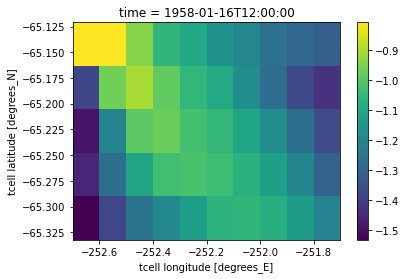

In [7]:
##test if temp is still working after the depth weighting
temp_400m[0,...].plot()

In [8]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_400m = (temp_400m*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum


In [9]:
temp_400m = temp_400m.load()

#### Detrend time series and apply rolling mean 

In [10]:
# Note we need to first detrend the data:
temp_400m_zad = detrend_dim(temp_400m,'time')
temp_400m_zadr = temp_400m_zad.rolling(time=12, center=True).mean()
temp_400m_r = temp_400m.rolling(time=12, center=True).mean()

### LOADING THE T SERIES WHERE I REMOVED THE SEASONAL CYCLE BY CREATING AND SUBSTRACTING A CLIMATOLOGY FROM
#### The idea of it is too do the correlations again and see if there is improvement. Code at "test_climatolofy.ipynb

#### clim_d is already detrended, but no rolling mean as we are trying to test against that method of removing the seasonal cycle. 

In [11]:
outpath = '/g/data/v45/ns3783/clim_d2.nc'
profile_data = xr.open_dataset(outpath)
clim_d = profile_data.clim_d

### ISOPYCNAL DEPTH 

In [12]:
# ORIGINAL
lon_slice  = slice(-253, -251.5)
lat_slice  = slice(-67.5, -63)

temp_iso = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso = temp_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

sal_iso = cc.querying.getvar(iaf_cycle3,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso = sal_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [13]:
# calculate density along transect:
# arrays for gsw to use
depth_array = temp_iso*0 + temp_iso.st_ocean
lat_array = temp_iso*0 + temp_iso.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(sal_iso,pressure,sal_iso.xt_ocean,lat_array)
#calculate sigma
sigma0 = gsw.sigma0(salt_abs,temp_iso)

In [14]:
# cut the data BOX 1
#lon_slice  = slice(-253, -251.5) #best
lat_slice  = slice(-65.3, -63)
lon_slice  = slice(-253.5, -251.1)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

MAKE MASK FOR BOX 1 offshore in between 1000 and 2000 isopycnals

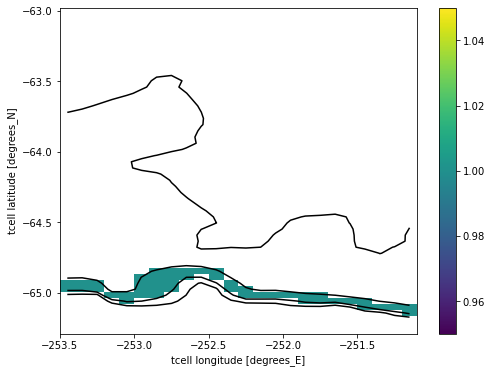

In [15]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_10002000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[700,1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [16]:
#apply the mask
sigma0_off = sigma0*region_mask
sigma0_off = sigma0_off.where(sigma0_off!=0)

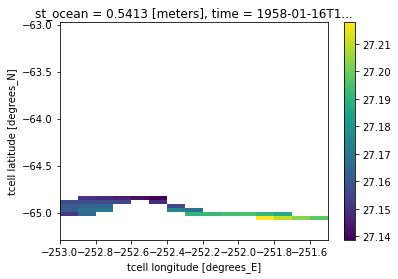

In [17]:
# first time step only:
sigma0_off[0,0,...].plot()

In [18]:
#load
sigma0_off=sigma0_off.load()

Incorporating Adele's method of calculating isopycnals.
Old method works fine, but averaging across lat/lon first means that your final depth values will be limited to values of st_ocean (i.e. quite discrete and widely spaced).
Try to find first depth where density > rho_thresh (27.82 looks like it might be around 500-600 m, i.e. at the depth of shelf break) at each lat/lon position, then average these depths after over lat/lon, which should make the final depth values have more variable values.

Using only the isopycnals that had the highest correlations with previous variables 27.82 and 27.83

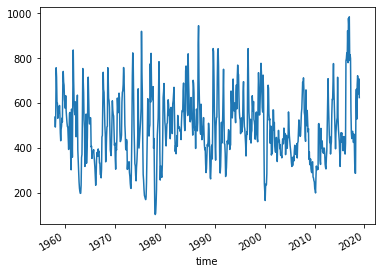

In [19]:
rho_thresh = 27.82

# mask density where < rho_thresh:
sigma0_off_mask = sigma0_off.where(sigma0_off>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array = sigma0_off*0 + sigma0_off.st_ocean
# mask depth array using density threshold:
depth_array_masked = depth_array.where(sigma0_off>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth = depth_array_masked.min(dim='st_ocean')

# now average that minimum depth over lat and lon:
min_depth_avg = min_depth.mean('xt_ocean').mean('yt_ocean')
min_depth_avg.plot()

#rename the isopycnal
iso2782_dth=min_depth_avg

In [20]:
#they are still xarrays until I load them
iso2782_dth=iso2782_dth.load()


### Apply rolling mean 

In [21]:
iso2782_dth_r = iso2782_dth.rolling(time=12, center=True).mean()



In [22]:
# Note we need to first detrend the data:
iso_detrended = detrend_dim(iso2782_dth,'time')

In [23]:
iso_detrended_r=iso_detrended.rolling(time=12, center=True).mean()

### ASC SPEED USING TRANSECT LINE

In [24]:
# depth limits chosen based on transects
depth_slice = slice(200, 500)
# set this to the rough region of interest:
#lat_slice  = slice(-65.5,-65.4)
#lat_slice  = -65
lat_slice  = slice(-66, -63)
lon_slice  = slice(-255, -248)
#get U general 
u_speed = cc.querying.getvar(iaf_cycle3,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)

2024-12-03 19:55:36,542 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2024-12-03 19:55:37,200 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-12-03 19:55:37,948 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2024-12-03 19:55:38,020 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [25]:
# load a sample slice of data to plot just for testing:
#temp_slice = temp.sel(st_ocean=400,method='nearest').isel(time=0)
u_slice = u_speed.sel(st_ocean=400,method='nearest').mean('time')
u_slice = u_slice.load()

# also get bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
ht = ht.load()

2024-12-03 19:55:59,994 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


In [26]:
u_slice

<xarray.DataArray 'u' (yu_ocean: 69, xu_ocean: 70)>
array([[ 0.00510614,  0.00146219, -0.00411599, ...,         nan,
                nan,         nan],
       [        nan,  0.00144473, -0.00422724, ...,         nan,
                nan,         nan],
       [        nan,  0.00359363, -0.00176692, ...,         nan,
                nan,         nan],
       ...,
       [-0.02645123, -0.0253588 , -0.02215718, ...,  0.03076813,
         0.03060459,  0.029538  ],
       [-0.02567865, -0.02534202, -0.02281484, ...,  0.02995209,
         0.02944377,  0.02830261],
       [-0.02163104, -0.02200456, -0.01986072, ...,  0.029411  ,
         0.02885071,  0.02749652]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -255.0 -254.9 -254.8 ... -248.3 -248.2 -248.1
  * yu_ocean  (yu_ocean) float64 -65.97 -65.92 -65.88 ... -63.11 -63.07 -63.02
    st_ocean  float64 383.0

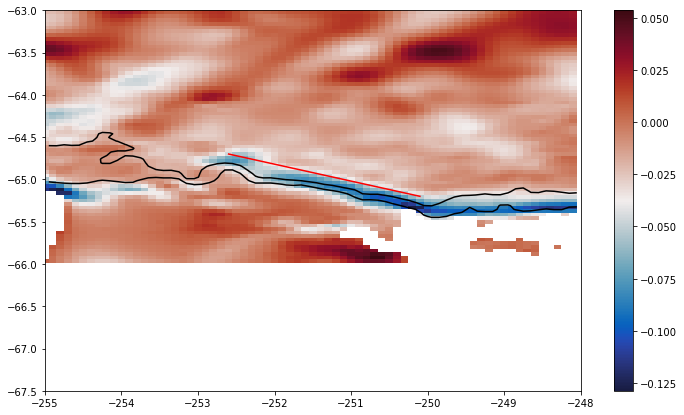

In [27]:
# define transect start and end points:
# Change these values until you get the transect you want:
lat0 = -64.7 #64.8
lat1= -65.2 #65.1
lon0 = -252.6 #252.1
lon1 = -250.1 #250.1

plt.figure(figsize=(12,7))

# plot temperature:
plt.pcolormesh(u_slice.xu_ocean,u_slice.yu_ocean,u_slice, cmap=cmocean.balance)#,
#              vmin=-2,vmax=1)
plt.colorbar()
#plt.clim((-2.1,.8))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r')
plt.xlim((-255, -248))
plt.ylim((-67.5, -63))
# plot bathymetry contours:
i=plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000],colors='k')

#save_results_to = '/g/data/jk72/ns3783/Round8'
#plt.savefig(save_results_to + 'transect_lat_IAF3.png', dpi=120,bbox_inches='tight', pad_inches=0.1)
#plt.savefig(save_results_to + 'transect_asc_trajectory+temp.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

In [28]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
lons = [lon0, lon1]
lats = [lat0, lat1]

yu_ocean = u_speed.yu_ocean


# get latitude of points along transect:
lat_transect = yu_ocean.sel(yu_ocean = slice(lats[1],lats[0])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yu_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yu_ocean')

# Extract temp and salt along transect:
u_transect = u_speed.sel(xu_ocean = lon_transect, yu_ocean = lat_transect, method = 'nearest')

u_transect = u_transect.load()

In [29]:
#u_transect

In [30]:
u_transect=u_transect.mean('yu_ocean').mean('st_ocean')

#### Detrend time series both ASC heat flux X and speed time series

In [31]:
#asc_X_d = detrend_dim(asc_heat_x,'time')
u_speed_td = detrend_dim(u_transect,'time')

#### Apply Rolling mean to them 

In [32]:
#asc_X_dr = asc_X_d.rolling(time=12, center=True).mean()
u_speed_tdr = u_speed_td.rolling(time=12, center=True).mean()

In [33]:
u_speed_tr = u_transect.rolling(time=12, center=True).mean()

## LOAD EKMAN right at the shelf. 
#### if you look in the same area of ASC doesn't work and the small area on the slope also didn't work 
#### what does work is a line between 700-1000m isobath runnign through mid-slope to the end of the eastern domain and that area just on the shelf. 

In [34]:
lon_slice  = slice(-256, 240) 
lat_slice  = slice(-67.5, -63)


# these are the values used by MOM5
sigma = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(iaf_cycle3,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

f = 2 * sigma * np.sin(np.deg2rad(geolat_c)) # convert lat in radians

In [35]:
#pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lon_slice  = slice(-256, -240) # TRY SAME AS ISOPYCNALS
lat_slice  = slice(-67.5, -63)


first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

tau_x_con = cc.querying.getvar(iaf_cycle3, 'tau_x', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(iaf_cycle3, 'tau_y', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_con = tau_y_con.load()

In [36]:
# database for control simulation:
control = '01deg_jra55v13_ryf9091'

# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
#dyu = dyu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice)

dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
#dxu = dxu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice)

2024-12-03 19:56:27,350 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2024-12-03 19:56:29,603 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-12-03 19:56:32,894 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


In [37]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = tau_y_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = tau_x_con/f
taux_f_con = taux_f_con.fillna(0)

In [38]:
# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_con = curl_tauf_con/rho0*s_day


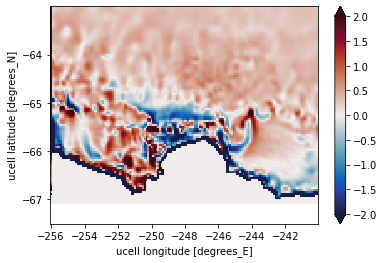

In [39]:
# quick check that this looks ok:
ekman_con.mean('time').plot(vmin=-2,vmax=2,cmap=cmocean.balance)

In [40]:
# cut the data BOX 1
#lon_slice  = slice(-253, -251.5) #best
lat_slice  = slice(-67, -64)
lon_slice  = slice(-255, -248)

# topography data:
hu = cc.querying.getvar(iaf_cycle3,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

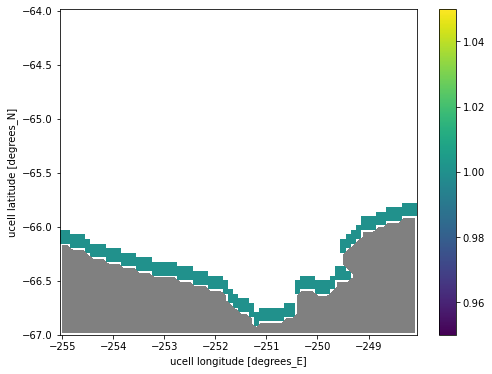

In [41]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U0m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=1)] = np.nan
shelf_mask = shelf_mask+0
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

plt.figure(figsize=(8,6))
region_mask.plot()
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[700,1000,2000,3000],colors='k')
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [42]:
#apply the mask
ekman_off = ekman_con*region_mask
ekman_off = ekman_off.where(ekman_off!=0)

In [43]:
ekman_off

<xarray.DataArray (time: 732, yu_ocean: 71, xu_ocean: 70)>
dask.array<where, shape=(732, 71, 70), dtype=float64, chunksize=(732, 71, 70), chunktype=numpy.ndarray>
Coordinates:
  * yu_ocean  (yu_ocean) float64 -66.98 -66.94 -66.9 ... -64.09 -64.05 -64.0
  * xu_ocean  (xu_ocean) float64 -255.0 -254.9 -254.8 ... -248.3 -248.2 -248.1
  * time      (time) datetime64[ns] 1958-01-16T12:00:00 ... 2018-12-16T12:00:00
    TLON      (yu_ocean, xu_ocean) float32 104.9 105.1 105.2 ... 111.8 111.8
    TLAT      (yu_ocean, xu_ocean) float32 -67.0 -67.0 -67.0 ... -64.03 -64.03
    ULON      (yu_ocean, xu_ocean) float32 -255.0 -254.9 ... -248.2 -248.1
    ULAT      (yu_ocean, xu_ocean) float32 -66.98 -66.98 -66.98 ... -64.0 -64.0

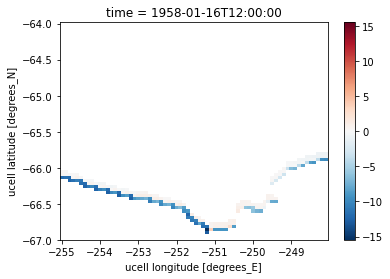

In [44]:
# first time step only:
ekman_off[0,...].plot()

In [45]:
#load
ekman_off=ekman_off.load()

In [46]:
#ekman_off=ekman_off.mean('yu_ocean').mean('xu_ocean')
ekman_off=ekman_off.sum('yu_ocean').sum('xu_ocean')

#### Detrend time series both ASC heat flux X and speed time series

In [47]:
#asc_X_d = detrend_dim(asc_heat_x,'time')
ekman_con_d = detrend_dim(ekman_off,'time')

#### Apply Rolling mean to them 

In [48]:
#asc_X_dr = asc_X_d.rolling(time=12, center=True).mean()
ekman_con_dr_shelf = ekman_con_d.rolling(time=12, center=True).mean()

In [49]:
ekman_con_r_shelf = ekman_off.rolling(time=12, center=True).mean()

## Ekman along the fine slope area 

In [50]:
lon_slice  = slice(-251, 245) 
lat_slice  = slice(-67.5, -63)


# these are the values used by MOM5
sigma = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(iaf_cycle3,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

f = 2 * sigma * np.sin(np.deg2rad(geolat_c)) # convert lat in radians


In [51]:
#pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lon_slice  = slice(-256, -245) # TRY SAME AS ISOPYCNALS
lat_slice  = slice(-67.5, -63)


first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

tau_x_con = cc.querying.getvar(iaf_cycle3, 'tau_x', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(iaf_cycle3, 'tau_y', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_con = tau_y_con.load()

In [52]:
# database for control simulation:
control = '01deg_jra55v13_ryf9091'

# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
#dyu = dyu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice)

dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
#dxu = dxu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice)

2024-12-03 19:56:58,484 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2024-12-03 19:56:59,337 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [53]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = tau_y_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = tau_x_con/f
taux_f_con = taux_f_con.fillna(0)

In [54]:
# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_con = curl_tauf_con/rho0*s_day


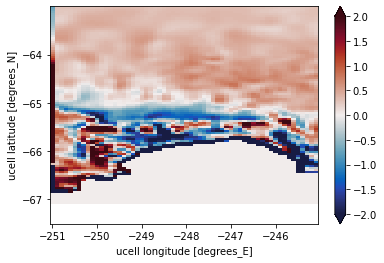

In [55]:
# quick check that this looks ok:
ekman_con.mean('time').plot(vmin=-2,vmax=2,cmap=cmocean.balance)

In [56]:
# cut the data BOX 1
#lon_slice  = slice(-252.3, -250.1) 
lon_slice  = slice(-251, -246) # best -251
#lon_slice  = slice(-253.5, -251.1)
lat_slice  = slice(-65.6, -63)

# topography data:
hu = cc.querying.getvar(iaf_cycle3,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

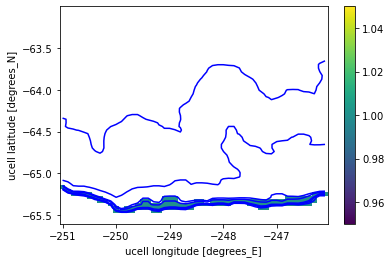

In [57]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U5001000m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
#i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000,2000,3000],colors='k')
i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[550,600,650,900,1050,2000,3000],colors='b')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [58]:
#apply the mask
ekman_con_off = ekman_con*region_mask
ekman_con_off = ekman_con_off.where(ekman_con_off!=0)

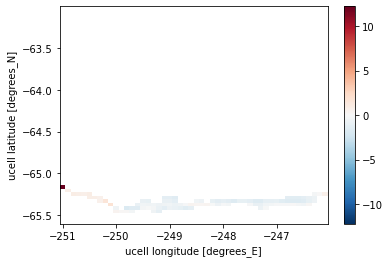

In [59]:
# first time step only:
ek=ekman_con_off.mean('time')
ek.plot()
#ekman_con_off[0,...].plot()

In [60]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_u = area_u*region_mask

# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
ekman_con_a = (ekman_con_off*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

In [61]:
ekman_con_s = ekman_con_off.sum('yu_ocean').sum('xu_ocean')
ekman_con_s = ekman_con_s.load()

In [62]:
#load the variable
ekman_con_a = ekman_con_a.load()

### detrend ekman series

In [63]:
# Note we need to first detrend the data:
ekman_con_d = detrend_dim(ekman_con_a,'time')
ekman_con_dr = ekman_con_d.rolling(time=12, center=True).mean()
ekman_con_r = ekman_con_a.rolling(time=12, center=True).mean()

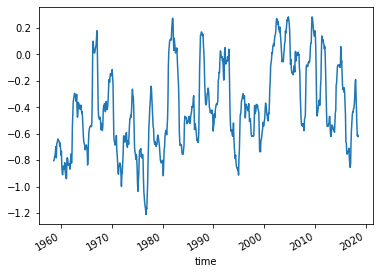

In [64]:
ekman_con_r.plot()


## ekman for outside slope

In [65]:
lon_slice  = slice(-251, 245) 
lat_slice  = slice(-67.5, -63)


# these are the values used by MOM5
sigma = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(iaf_cycle3,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

f = 2 * sigma * np.sin(np.deg2rad(geolat_c)) # convert lat in radians


In [66]:
#pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lon_slice  = slice(-256, -245) # TRY SAME AS ISOPYCNALS
lat_slice  = slice(-67.5, -63)


first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

tau_x_con = cc.querying.getvar(iaf_cycle3, 'tau_x', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(iaf_cycle3, 'tau_y', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_con = tau_y_con.load()

2024-12-03 19:57:09,595 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


In [67]:
# database for control simulation:
control = '01deg_jra55v13_ryf9091'

# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
#dyu = dyu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice)

dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
#dxu = dxu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice)

In [68]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = tau_y_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = tau_x_con/f
taux_f_con = taux_f_con.fillna(0)

In [69]:
# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_con = curl_tauf_con/rho0*s_day


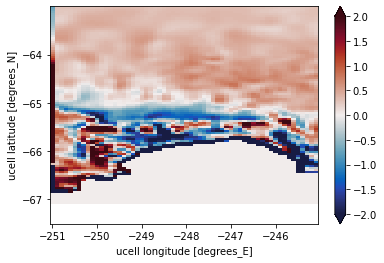

In [70]:
# quick check that this looks ok:
ekman_con.mean('time').plot(vmin=-2,vmax=2,cmap=cmocean.balance)

In [71]:
# cut the data BOX 1
#lon_slice  = slice(-252.3, -250.1) 
lon_slice  = slice(-251, -246) # best -251
#lon_slice  = slice(-253.5, -251.1)
lat_slice  = slice(-65.6, -63)

# topography data:
hu = cc.querying.getvar(iaf_cycle3,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

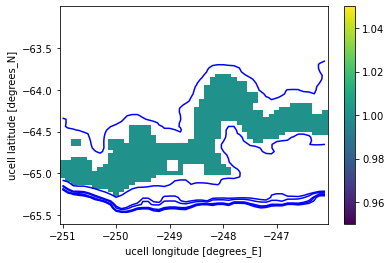

In [72]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U22002800m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
#i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000,2000,3000],colors='k')
i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[550,600,650,900,1050,2000,3000],colors='b')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [73]:
#apply the mask
ekman_con_off = ekman_con*region_mask
ekman_con_off = ekman_con_off.where(ekman_con_off!=0)

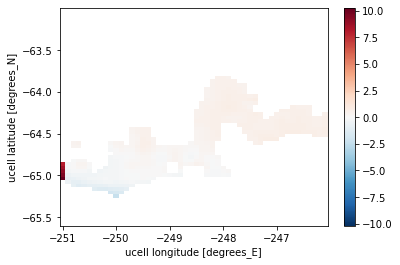

In [74]:
# first time step only:
ek=ekman_con_off.mean('time')
ek.plot()
#ekman_con_off[0,...].plot()

In [75]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_u = area_u*region_mask

# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
ekman_con_a = (ekman_con_off*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

In [76]:
ekman_con_s = ekman_con_off.sum('yu_ocean').sum('xu_ocean')
ekman_con_s = ekman_con_s.load()

In [77]:
#load the variable
ekman_con_a = ekman_con_a.load()

### detrend ekman series

In [78]:
# Note we need to first detrend the data:
ekman_con_d_offslope = detrend_dim(ekman_con_a,'time')
ekman_con_dr_offslope = ekman_con_d_offslope.rolling(time=12, center=True).mean()
ekman_con_r_offslope = ekman_con_a.rolling(time=12, center=True).mean()

In [79]:
#ek_transect_dr
ekman_temp_sh=ekman_con_r
ekman_temp_sh=ekman_temp_sh.shift(time=-2).dropna(dim='time')

ekman_iso_sh=ekman_con_r
#ekman_iso_sh=ekman_iso_sh.shift(time=-3).dropna(dim='time')

#ekman_asc_sh=ekman_con_r
#ekman_asc_sh=ekman_asc_sh.shift(time=-7).dropna(dim='time')


2024-12-03 19:58:25,367 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2024-12-03 20:03:03,696 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-03 20:03:20,744 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


### PLOT TIME SERIES FOR FIGURE 

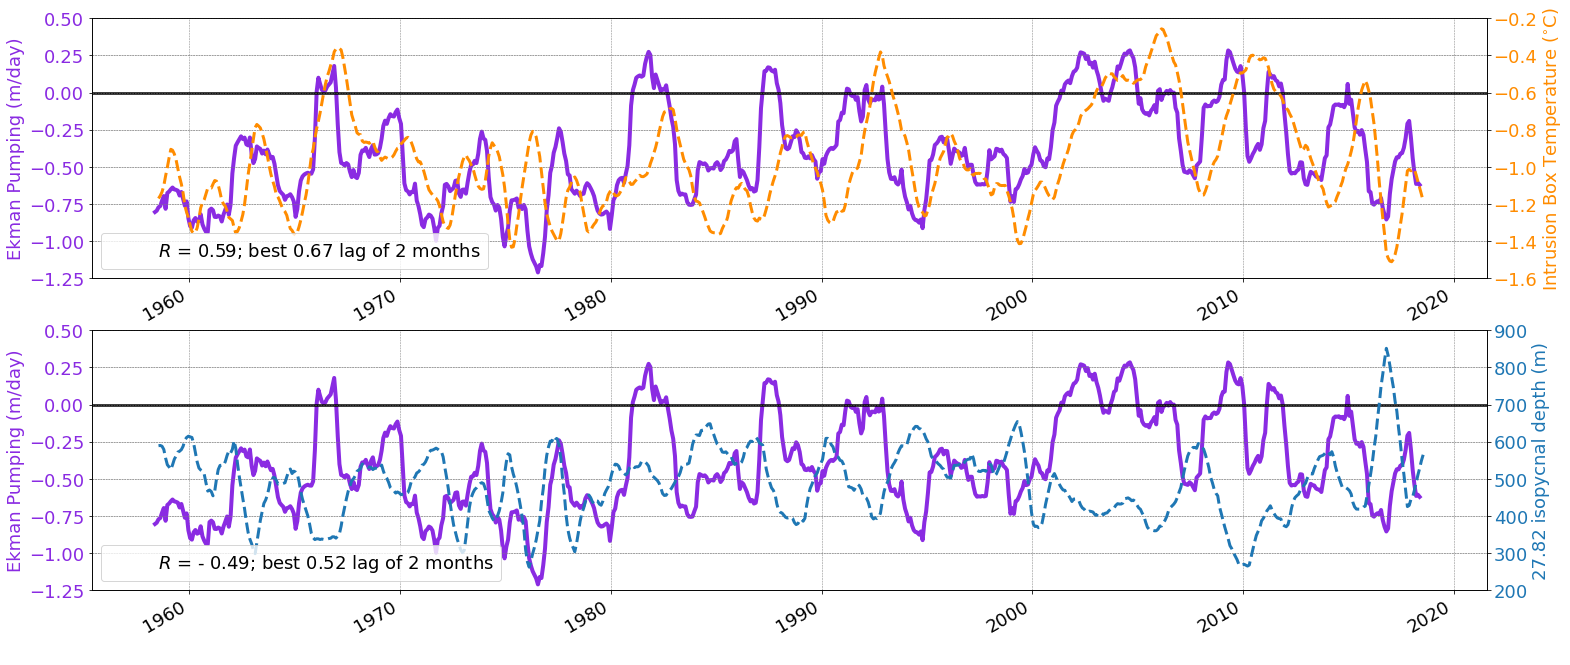

In [85]:
fontsize=18
fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)


ax1 = plt.subplot(4, 1, 1)
ekman_temp_sh.plot(color='blueviolet',linewidth=4)
ax1.set_ylabel('Ekman Pumping (m/day)', fontsize=fontsize,color='blueviolet')
ax1.tick_params(axis='y', labelcolor='blueviolet',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
#plt.title('Monthly T (Box1) vs Zonal Wind (small grid; -65,-64.5S/-258,-252E) / Rolling mean',fontsize=fontsize)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax1.axhline(y=0, color='black', linewidth=2.5)
plt.ylim([-1.25,0.5])
#plt.text(100,0.4,"cor = -0.73, lag = 4 months")

ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
temp_400m_r.plot(color='darkorange',linestyle='--',linewidth=3)
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('Intrusion Box Temperature ($^{\circ}$C)', fontsize=fontsize, color='darkorange')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='darkorange',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='k',linestyle='none',label='$R$ = 0.59; best 0.67 lag of 2 months')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="lower left",fontsize=fontsize)
plt.ylim([-1.6,-0.2])


ax1 = plt.subplot(4, 1, 2)
ekman_temp_sh.plot(color='blueviolet',linewidth=4)
ax1.set_ylabel('Ekman Pumping (m/day)', fontsize=fontsize,color='blueviolet')
ax1.tick_params(axis='y', labelcolor='blueviolet',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
#plt.title('Monthly T (Box1) vs Zonal Wind (small grid; -65,-64.5S/-258,-252E) / Rolling mean',fontsize=fontsize)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax1.axhline(y=0, color='black', linewidth=2.5)
plt.ylim([-1.25,0.5])
#plt.text(100,0.4,"cor = -0.73, lag = 4 months")

ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
iso2782_dth_r.plot(color='C0',linestyle='--',linewidth=3)
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('27.82 isopycnal depth (m)', fontsize=fontsize, color='C0')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='C0',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='k',linestyle='none',label='$R$ = - 0.49; best 0.52 lag of 2 months')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="lower left",fontsize=fontsize)
plt.ylim([200,900])

# ax1 = plt.subplot(4, 1, 3)
# ekman_asc_sh.plot(color='gold',linewidth=4)
# ax1.set_ylabel('Ekman Pump (m/day)', fontsize=fontsize,color='green')
# ax1.tick_params(axis='y', labelcolor='green',labelsize=fontsize)
# ax1.set_xlabel(' ', fontsize = fontsize)
# ax1.tick_params(axis='x',labelsize=fontsize)
# plt.title(' ')
# plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
# plt.ylim([-1.25,0.5])
# #plt.text(100,0.4,"cor = -0.73, lag = 4 months")


# ax2 = ax1.twinx()
# #isocon_off_dr.plot(color='C0')
# u_speed_tr.plot(color='blueviolet',linestyle='--',linewidth=3)
# #isocon_off3_dr.plot(color='C0',linestyle=':')
# ax2.set_ylabel('ASC (m/s)', fontsize=fontsize, color='blueviolet')
# ax2.tick_params(axis='x',labelsize=fontsize)
# ax2.tick_params(axis='y', labelcolor='blueviolet',labelsize=fontsize)
# plt.ylim([-0.09,0.01])
# #ax2.invert_yaxis()
# plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
# #plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
# #building legend
# #plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
# plt.plot(np.nan,np.nan,color='k',marker=".",linestyle='none',label='cor = 0.1; best 0.4 lag of 7 months')
# #plt.plot(np.nan,np.nan,color='C0',label='27.83')
# plt.legend(loc="lower left",fontsize=fontsize)



figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
###figdir = '/g/data/jk72/ns3783'
filestr = figdir+'/fig6_ekman_time_series.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [79]:
pwd

'/home/581/ns3783/Scripts/Figures/New_codes_CFD'

In [115]:
clim_d

<xarray.DataArray 'clim_d' (time: 732)>
array([-0.05268 , -0.088283, -0.05453 , ..., -0.439102, -0.38037 , -0.451364])
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2018-12-01

In [93]:
temp_400m_zadr

<xarray.DataArray (time: 732)>
array([        nan,         nan,         nan,         nan,         nan,
               nan, -0.07018906, -0.05520698, -0.03507509, -0.00217384,
        0.04911265,  0.09496774,  0.14769219,  0.19215728,  0.1868588 ,
        0.16676915,  0.13501883,  0.08915783,  0.04150049,  0.00290253,
       -0.04663289, -0.1141898 , -0.15110152, -0.17835044, -0.22105709,
       -0.25439816, -0.26463244, -0.25960866, -0.23634473, -0.18791852,
       -0.12940987, -0.10171871, -0.08567117, -0.05514784, -0.02417137,
       -0.02337153, -0.02466388, -0.00364799,  0.01504928,  0.01135208,
       -0.00984132, -0.04836469, -0.09332945, -0.11371027, -0.12521956,
       -0.15156378, -0.18636556, -0.19475566, -0.20378845, -0.24280521,
       -0.27260102, -0.26327626, -0.24345176, -0.20995418, -0.17408202,
       -0.11656828, -0.04093463,  0.03991905,  0.10165937,  0.16792304,
        0.23203606,  0.2924948 ,  0.30838586,  0.29980892,  0.28882072,
        0.26021669,  0.22798466,  0.18171343,  0.13538497,  0.08227804,
        0.03669706,  0.00189229, -0.02970232, -0.07172683, -0.08663456,
       -0.10804122, -0.13406096, -0.15622985, -0.16701226, -0.18727639,
       -0.22645952, -0.25908958, -0.2693403 , -0.28781403, -0.29530965,
       -0.27998973, -0.25143244, -0.21581568, -0.17214441, -0.12434629,
       -0.08062973, -0.02152563,  0.05075724,  0.12593765,  0.16316918,
        0.22271358,  0.27437683,  0.31415078,  0.35749469,  0.41146715,
...
        0.46250019,  0.45889361,  0.43626296,  0.40835274,  0.35987384,
        0.31969138,  0.29188126,  0.2791251 ,  0.26832204,  0.26332276,
        0.25218526,  0.23103745,  0.20045229,  0.18553905,  0.17699091,
        0.15554456,  0.13687426,  0.11139377,  0.07860395,  0.04857756,
        0.01394671, -0.01783165, -0.04610745, -0.03611172, -0.01733857,
       -0.02794045, -0.05954314, -0.08996442, -0.1164718 , -0.14194673,
       -0.16694235, -0.19603476, -0.22480471, -0.23909904, -0.2564858 ,
       -0.29985174, -0.33036617, -0.35450509, -0.35024401, -0.34543194,
       -0.33353821, -0.32615651, -0.29976926, -0.27789053, -0.24480503,
       -0.22001569, -0.180493  , -0.15060658, -0.12855207, -0.09577131,
       -0.06064734, -0.0204273 ,  0.03867831,  0.10595238,  0.17196171,
        0.22480239,  0.26900682,  0.29616734,  0.31878081,  0.29886543,
        0.26321818,  0.21881922,  0.15174182,  0.08504536, -0.0105725 ,
       -0.11327286, -0.23176585, -0.32926088, -0.42756093, -0.51473641,
       -0.61517958, -0.64110041, -0.65802328, -0.66193484, -0.64966627,
       -0.62406526, -0.58501684, -0.52839956, -0.46625539, -0.40484854,
       -0.32738087, -0.25411465, -0.1755728 , -0.16812201, -0.17616606,
       -0.16865339, -0.1696175 , -0.19917772, -0.23381335, -0.26919013,
       -0.30435642, -0.34345345,         nan,         nan,         nan,
               nan,         nan])
Coordinates:
  * time     (time) datetime64[ns] 1958-01-16T12:00:00 ... 2018-12-16T12:00:00

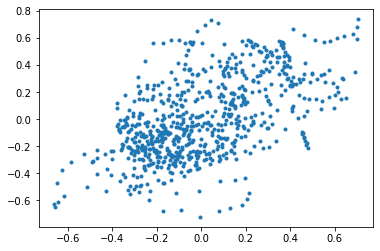

In [113]:
plt.plot(temp_400m_zadr,ekman_con_dr,'.')


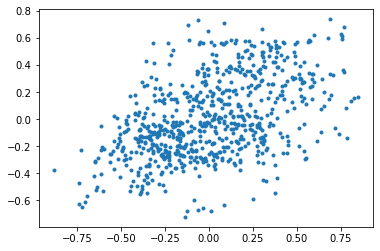

In [114]:
plt.plot(clim_d,ekman_con_dr,'.')

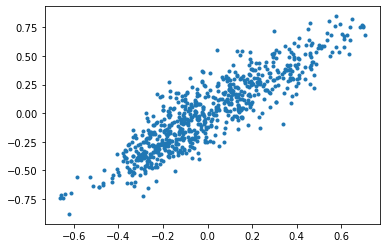

In [124]:
plt.plot(temp_400m_zadr,clim_d,'.')

In [121]:
xr.corr(temp_400m_zadr,ekman_con_dr)

<xarray.DataArray ()>
array(0.55116934)

### CORRELATIONS WITH EKMAN SLOPE

In [80]:
cov1,cor_temp,slope1,intercept1,pval_temp,stderr1 = lag_linregress_3D(ekman_con_dr,temp_400m_zadr,lagx=0,lagy=3)
cov1,cor_clim,slope1,intercept1,pval_temp,stderr1 = lag_linregress_3D(ekman_con_dr,clim_d,lagx=0,lagy=3)
cov2,cor_iso,slope2,intercept2,pval_iso,stderr2 = lag_linregress_3D(ekman_con_dr,iso2782_dth_r,lagx=0,lagy=1)
cov2,cor_ekman,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(u_speed_tr,ekman_con_dr,lagx=7,lagy=0)
cov2,cor_ekman_ek,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(ekman_con_dr_offslope,ekman_con_dr,lagx=0,lagy=0)

print('Cor EKMAN vs TEMP',cor_temp) 
print('Cor EKMAN vs CLIM',cor_clim) 
print('Cor EKMAN vs ISO',cor_iso)
print('Cor EKMAN vs ASC',cor_ekman)
print('Cor EKMAN SLOPE vs EKMNA OFF',cor_ekman_ek)


Cor EKMAN vs TEMP <xarray.DataArray ()>
array(0.67315704)
Cor EKMAN vs CLIM <xarray.DataArray ()>
array(0.59383568)
Cor EKMAN vs ISO <xarray.DataArray ()>
array(-0.49350909)
Cor EKMAN vs ASC <xarray.DataArray ()>
array(0.33897106)
Cor EKMAN SLOPE vs EKMNA OFF <xarray.DataArray ()>
array(0.21592258)


In [81]:
# AA
s=10;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(iso2782_dth_r,ekman_con_dr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -9 :  <xarray.DataArray ()>
array(-0.31295613)
lag -8 :  <xarray.DataArray ()>
array(-0.36532256)
lag -7 :  <xarray.DataArray ()>
array(-0.41238914)
lag -6 :  <xarray.DataArray ()>
array(-0.45143057)
lag -5 :  <xarray.DataArray ()>
array(-0.48168253)
lag -4 :  <xarray.DataArray ()>
array(-0.50250026)
lag -3 :  <xarray.DataArray ()>
array(-0.51483267)
lag -2 :  <xarray.DataArray ()>
array(-0.5183648)
lag -1 :  <xarray.DataArray ()>
array(-0.51166213)
lag 0 :  <xarray.DataArray ()>
array(-0.49321339)


2023-04-16 17:38:10,909 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


In [209]:
# AA
s=20;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(temp_400m_zadr,ekman_con_dr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -19 :  <xarray.DataArray ()>
array(0.31742137)
lag -18 :  <xarray.DataArray ()>
array(0.35111192)
lag -17 :  <xarray.DataArray ()>
array(0.3852705)
lag -16 :  <xarray.DataArray ()>
array(0.420106)
lag -15 :  <xarray.DataArray ()>
array(0.45624445)
lag -14 :  <xarray.DataArray ()>
array(0.49360378)
lag -13 :  <xarray.DataArray ()>
array(0.53189109)
lag -12 :  <xarray.DataArray ()>
array(0.57057988)
lag -11 :  <xarray.DataArray ()>
array(0.60803774)
lag -10 :  <xarray.DataArray ()>
array(0.64155106)
lag -9 :  <xarray.DataArray ()>
array(0.66979019)
lag -8 :  <xarray.DataArray ()>
array(0.69187293)
lag -7 :  <xarray.DataArray ()>
array(0.70737858)
lag -6 :  <xarray.DataArray ()>
array(0.71467665)
lag -5 :  <xarray.DataArray ()>
array(0.71446378)
lag -4 :  <xarray.DataArray ()>
array(0.70673588)
lag -3 :  <xarray.DataArray ()>
array(0.69272909)
lag -2 :  <xarray.DataArray ()>
array(0.67035939)
lag -1 :  <xarray.DataArray ()>
array(0.63917997)
lag 0 :  <xarray.DataArray ()>
array(0.5987

In [ ]:
# AA
s=15;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(iso_detrended_r,temp_400m_zadr,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

lag -14 :  <xarray.DataArray ()>
array(nan)
lag -13 :  <xarray.DataArray ()>
array(nan)
lag -12 :  <xarray.DataArray ()>
array(nan)
lag -11 :  <xarray.DataArray ()>
array(nan)
lag -10 :  <xarray.DataArray ()>
array(nan)
lag -9 :  <xarray.DataArray ()>
array(nan)
lag -8 :  <xarray.DataArray ()>
array(nan)
lag -7 :  <xarray.DataArray ()>
array(nan)
lag -6 :  <xarray.DataArray ()>
array(nan)
lag -5 :  <xarray.DataArray ()>
array(nan)
lag -4 :  <xarray.DataArray ()>
array(nan)
lag -3 :  <xarray.DataArray ()>
array(nan)
lag -2 :  <xarray.DataArray ()>
array(nan)
lag -1 :  <xarray.DataArray ()>
array(nan)
lag 0 :  <xarray.DataArray ()>
array(nan)


In [91]:
# AA
s=15;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(iso_detrended,temp_400m_zad,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

lag -14 :  <xarray.DataArray ()>
array(-0.16769833)
lag -13 :  <xarray.DataArray ()>
array(-0.20552712)
lag -12 :  <xarray.DataArray ()>
array(-0.21177457)
lag -11 :  <xarray.DataArray ()>
array(-0.18291488)
lag -10 :  <xarray.DataArray ()>
array(-0.1363963)
lag -9 :  <xarray.DataArray ()>
array(-0.09313487)
lag -8 :  <xarray.DataArray ()>
array(-0.08846214)
lag -7 :  <xarray.DataArray ()>
array(-0.13492024)
lag -6 :  <xarray.DataArray ()>
array(-0.21480263)
lag -5 :  <xarray.DataArray ()>
array(-0.31146276)
lag -4 :  <xarray.DataArray ()>
array(-0.40708698)
lag -3 :  <xarray.DataArray ()>
array(-0.4977822)
lag -2 :  <xarray.DataArray ()>
array(-0.58402933)
lag -1 :  <xarray.DataArray ()>
array(-0.65239556)
lag 0 :  <xarray.DataArray ()>
array(-0.69206748)


In [88]:
# AA
s=10;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(u_speed_tr,ekman_con_dr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -9 :  <xarray.DataArray ()>
array(0.33324)
lag -8 :  <xarray.DataArray ()>
array(0.34455258)
lag -7 :  <xarray.DataArray ()>
array(0.34717612)
lag -6 :  <xarray.DataArray ()>
array(0.33837897)
lag -5 :  <xarray.DataArray ()>
array(0.32110723)
lag -4 :  <xarray.DataArray ()>
array(0.29815569)
lag -3 :  <xarray.DataArray ()>
array(0.26812129)
lag -2 :  <xarray.DataArray ()>
array(0.23310059)
lag -1 :  <xarray.DataArray ()>
array(0.19252977)
lag 0 :  <xarray.DataArray ()>
array(0.14689109)


### CORRELATIONS WITH EKMAN SHELF

In [81]:
cov1,cor_temp,slope1,intercept1,pval_temp,stderr1 = lag_linregress_3D(ekman_con_dr_shelf,temp_400m_zadr,lagx=0,lagy=3)
cov1,cor_clim,slope1,intercept1,pval_temp,stderr1 = lag_linregress_3D(ekman_con_dr_shelf,clim_d,lagx=0,lagy=3)
cov2,cor_iso,slope2,intercept2,pval_iso,stderr2 = lag_linregress_3D(ekman_con_dr_shelf,iso2782_dth_r,lagx=0,lagy=0)
cov2,cor_ekman,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(u_speed_tr,ekman_con_dr_shelf,lagx=0,lagy=0)

print('Cor EKMAN vs TEMP',cor_temp) 
print('Cor EKMAN vs CLIM',cor_clim)
print('Cor EKMAN vs ISO',cor_iso)
print('Cor EKMAN vs ASC',cor_ekman)


Cor EKMAN vs TEMP <xarray.DataArray ()>
array(0.01654704)
Cor EKMAN vs CLIM <xarray.DataArray ()>
array(0.04129146)
Cor EKMAN vs ISO <xarray.DataArray ()>
array(-0.04482721)
Cor EKMAN vs ASC <xarray.DataArray ()>
array(0.0892826)


In [86]:
# AA
s=10;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(iso2782_dth_r,ekman_con_dr_shelf,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -9 :  <xarray.DataArray ()>
array(0.08708731)
lag -8 :  <xarray.DataArray ()>
array(0.06689723)
lag -7 :  <xarray.DataArray ()>
array(0.04339477)
lag -6 :  <xarray.DataArray ()>
array(0.01923731)
lag -5 :  <xarray.DataArray ()>
array(-0.00314808)
lag -4 :  <xarray.DataArray ()>
array(-0.02408547)
lag -3 :  <xarray.DataArray ()>
array(-0.03919648)
lag -2 :  <xarray.DataArray ()>
array(-0.0487335)
lag -1 :  <xarray.DataArray ()>
array(-0.05454671)
lag 0 :  <xarray.DataArray ()>
array(-0.05449877)


In [87]:
# AA
s=10;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(temp_400m_zadr,ekman_con_dr_shelf,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -9 :  <xarray.DataArray ()>
array(-0.11650739)
lag -8 :  <xarray.DataArray ()>
array(-0.09286298)
lag -7 :  <xarray.DataArray ()>
array(-0.06895322)
lag -6 :  <xarray.DataArray ()>
array(-0.04611083)
lag -5 :  <xarray.DataArray ()>
array(-0.02446679)
lag -4 :  <xarray.DataArray ()>
array(-0.00491557)
lag -3 :  <xarray.DataArray ()>
array(0.00930986)
lag -2 :  <xarray.DataArray ()>
array(0.01654697)
lag -1 :  <xarray.DataArray ()>
array(0.01990557)
lag 0 :  <xarray.DataArray ()>
array(0.01722752)


In [88]:
# AA
s=15;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(u_speed_tr,ekman_con_dr_shelf,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -14 :  <xarray.DataArray ()>
array(0.03493865)
lag -13 :  <xarray.DataArray ()>
array(0.04070314)
lag -12 :  <xarray.DataArray ()>
array(0.04870899)
lag -11 :  <xarray.DataArray ()>
array(0.0652682)
lag -10 :  <xarray.DataArray ()>
array(0.08635464)
lag -9 :  <xarray.DataArray ()>
array(0.10522238)
lag -8 :  <xarray.DataArray ()>
array(0.12072806)
lag -7 :  <xarray.DataArray ()>
array(0.13793004)
lag -6 :  <xarray.DataArray ()>
array(0.15102225)
lag -5 :  <xarray.DataArray ()>
array(0.16110951)
lag -4 :  <xarray.DataArray ()>
array(0.1688396)
lag -3 :  <xarray.DataArray ()>
array(0.16701873)
lag -2 :  <xarray.DataArray ()>
array(0.15837646)
lag -1 :  <xarray.DataArray ()>
array(0.14490672)
lag 0 :  <xarray.DataArray ()>
array(0.1251764)


### CORRELATIONS WITH EKMAN OFF SLOPE 

In [82]:
cov1,cor_temp,slope1,intercept1,pval_temp,stderr1 = lag_linregress_3D(ekman_con_dr_offslope,temp_400m_zadr,lagx=0,lagy=6)
cov1,cor_clim,slope1,intercept1,pval_temp,stderr1 = lag_linregress_3D(ekman_con_dr_offslope,clim_d,lagx=0,lagy=6)
cov2,cor_iso,slope2,intercept2,pval_iso,stderr2 = lag_linregress_3D(ekman_con_dr_offslope,iso2782_dth_r,lagx=8,lagy=0)
cov2,cor_ekman,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(u_speed_tr,ekman_con_dr_offslope,lagx=0,lagy=0)

print('Cor EKMAN vs TEMP',cor_temp) 
print('Cor EKMAN vs CLIM',cor_clim) 
print('Cor EKMAN vs ISO',cor_iso)
print('Cor EKMAN vs ASC',cor_ekman)


Cor EKMAN vs TEMP <xarray.DataArray ()>
array(0.24281491)
Cor EKMAN vs CLIM <xarray.DataArray ()>
array(0.21787889)
Cor EKMAN vs ISO <xarray.DataArray ()>
array(-0.22931407)
Cor EKMAN vs ASC <xarray.DataArray ()>
array(0.42643552)


In [90]:
# AA
s=10;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(iso2782_dth_r,ekman_con_dr_offslope,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -9 :  <xarray.DataArray ()>
array(0.10091586)
lag -8 :  <xarray.DataArray ()>
array(0.09428245)
lag -7 :  <xarray.DataArray ()>
array(0.07958809)
lag -6 :  <xarray.DataArray ()>
array(0.05787477)
lag -5 :  <xarray.DataArray ()>
array(0.03263578)
lag -4 :  <xarray.DataArray ()>
array(0.00394672)
lag -3 :  <xarray.DataArray ()>
array(-0.02890439)
lag -2 :  <xarray.DataArray ()>
array(-0.0633182)
lag -1 :  <xarray.DataArray ()>
array(-0.09663098)
lag 0 :  <xarray.DataArray ()>
array(-0.12907674)


In [91]:
# AA
s=10;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(temp_400m_zadr,ekman_con_dr_offslope,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -9 :  <xarray.DataArray ()>
array(0.14623687)
lag -8 :  <xarray.DataArray ()>
array(0.16793698)
lag -7 :  <xarray.DataArray ()>
array(0.19195422)
lag -6 :  <xarray.DataArray ()>
array(0.21794144)
lag -5 :  <xarray.DataArray ()>
array(0.24226401)
lag -4 :  <xarray.DataArray ()>
array(0.26556701)
lag -3 :  <xarray.DataArray ()>
array(0.288468)
lag -2 :  <xarray.DataArray ()>
array(0.30877084)
lag -1 :  <xarray.DataArray ()>
array(0.32235893)
lag 0 :  <xarray.DataArray ()>
array(0.32927865)


In [92]:
# AA
s=15;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(u_speed_tr,ekman_con_dr_offslope,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -14 :  <xarray.DataArray ()>
array(-0.05315238)
lag -13 :  <xarray.DataArray ()>
array(-0.05827793)
lag -12 :  <xarray.DataArray ()>
array(-0.05406724)
lag -11 :  <xarray.DataArray ()>
array(-0.03992376)
lag -10 :  <xarray.DataArray ()>
array(-0.01099071)
lag -9 :  <xarray.DataArray ()>
array(0.02745125)
lag -8 :  <xarray.DataArray ()>
array(0.07044143)
lag -7 :  <xarray.DataArray ()>
array(0.11378361)
lag -6 :  <xarray.DataArray ()>
array(0.15720885)
lag -5 :  <xarray.DataArray ()>
array(0.19865092)
lag -4 :  <xarray.DataArray ()>
array(0.24039277)
lag -3 :  <xarray.DataArray ()>
array(0.28614651)
lag -2 :  <xarray.DataArray ()>
array(0.33242984)
lag -1 :  <xarray.DataArray ()>
array(0.37436648)
lag 0 :  <xarray.DataArray ()>
array(0.40899421)


### CORRELATIONS WITH ASC

In [83]:
cov1,cor_temp,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(u_speed_tr,temp_400m_zadr)
cov1,cor_clim,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(u_speed_tr,clim_d)
cov2,cor_iso,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(u_speed_tr,iso2782_dth_r)
cov2,cor_ekman,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(u_speed_tr,ekman_con_dr)

print('Cor ASC vs TEMP',cor_temp) 
print('Cor ASC vs CLIM',cor_clim) 
print('Cor ASC vs ISO',cor_iso)
print('Cor ASC vs EKMAN SLOPE',cor_ekman)


Cor ASC vs TEMP <xarray.DataArray ()>
array(0.46063771)
Cor ASC vs CLIM <xarray.DataArray ()>
array(0.44502542)
Cor ASC vs ISO <xarray.DataArray ()>
array(-0.36616344)
Cor ASC vs EKMAN SLOPE <xarray.DataArray ()>
array(0.09618177)


In [94]:
# AA
s=10;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(iso2782_dth_r,u_speed_tr,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

lag -9 :  <xarray.DataArray ()>
array(-0.23511561)
lag -8 :  <xarray.DataArray ()>
array(-0.30008821)
lag -7 :  <xarray.DataArray ()>
array(-0.36150481)
lag -6 :  <xarray.DataArray ()>
array(-0.4150075)
lag -5 :  <xarray.DataArray ()>
array(-0.45779717)
lag -4 :  <xarray.DataArray ()>
array(-0.48682986)
lag -3 :  <xarray.DataArray ()>
array(-0.50012786)
lag -2 :  <xarray.DataArray ()>
array(-0.49567822)
lag -1 :  <xarray.DataArray ()>
array(-0.47260358)
lag 0 :  <xarray.DataArray ()>
array(-0.43089179)


In [ ]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(u_speed_tr,temp_400m_zadr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -10 :  <xarray.DataArray ()>
array(0.1062491)
lag -9 :  <xarray.DataArray ()>
array(0.06597358)
lag -8 :  <xarray.DataArray ()>
array(0.01426687)
lag -7 :  <xarray.DataArray ()>
array(-0.04856176)
lag -6 :  <xarray.DataArray ()>
array(-0.12083471)
lag -5 :  <xarray.DataArray ()>
array(-0.2001916)
lag -4 :  <xarray.DataArray ()>
array(-0.28387409)
lag -3 :  <xarray.DataArray ()>
array(-0.36954174)
lag -2 :  <xarray.DataArray ()>
array(-0.45311552)
lag -1 :  <xarray.DataArray ()>
array(-0.53147005)
lag 0 :  <xarray.DataArray ()>
array(-0.6015749)


In [96]:
# AA
s=15;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(u_speed_tr,ekman_con_dr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -14 :  <xarray.DataArray ()>
array(0.19255951)
lag -13 :  <xarray.DataArray ()>
array(0.22578196)
lag -12 :  <xarray.DataArray ()>
array(0.25860285)
lag -11 :  <xarray.DataArray ()>
array(0.28853023)
lag -10 :  <xarray.DataArray ()>
array(0.31483227)
lag -9 :  <xarray.DataArray ()>
array(0.33324)
lag -8 :  <xarray.DataArray ()>
array(0.34455258)
lag -7 :  <xarray.DataArray ()>
array(0.34717612)
lag -6 :  <xarray.DataArray ()>
array(0.33837897)
lag -5 :  <xarray.DataArray ()>
array(0.32110723)
lag -4 :  <xarray.DataArray ()>
array(0.29815569)
lag -3 :  <xarray.DataArray ()>
array(0.26812129)
lag -2 :  <xarray.DataArray ()>
array(0.23310059)
lag -1 :  <xarray.DataArray ()>
array(0.19252977)
lag 0 :  <xarray.DataArray ()>
array(0.14689109)


### CORRELATIONS WITH ISO

In [84]:
cov1,cor_temp,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(iso2782_dth_r,temp_400m_zadr)
cov1,cor_clim,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(iso2782_dth_r,clim_d)
#cov2,cor_iso,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(u_speed_dr2,iso2782_dth_r)
#cov1,cor_salt,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(iso2782_dth_r,sal_za_dr)
#cov2,cor_age,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(iso2782_dth_r,bottom_age_adr)
cov2,cor_ekman,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(iso2782_dth_r,ekman_con_dr)
#cov2,cor_ekman2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(iso2782_dth_r,ekman_con_sdr)
#cov2,cor_ekman_trans,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(iso2782_dth_r,ek_transect_dr)
print('Cor ISO vs TEMP',cor_temp)
print('Cor ISO vs TEMP',cor_clim)
#print('Cor ISO vs ASC',cor_iso)


#print('Cor ISO vs SAL',cor_salt)
#print('Cor ISO vs AGE',cor_age)
print('Cor ISO vs EKMAN SLOPE',cor_ekman)
#print('Cor ISO vs EKMAN SHELF',cor_ekman2)
#print('Cor ISO vs EKMAN TRANS',cor_ekman_trans)

Cor ISO vs TEMP <xarray.DataArray ()>
array(-0.64945427)
Cor ISO vs TEMP <xarray.DataArray ()>
array(-0.63537604)
Cor ISO vs EKMAN SLOPE <xarray.DataArray ()>
array(-0.45554475)


In [144]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(ekman_con_dr2,u_speed_dr,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

NameError: name 'ekman_con_dr2' is not defined

In [145]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(ekman_con_dr,iso2782_dth_r,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

lag -10 :  <xarray.DataArray ()>
array(-0.25832214)
lag -9 :  <xarray.DataArray ()>
array(-0.31295613)
lag -8 :  <xarray.DataArray ()>
array(-0.36532256)
lag -7 :  <xarray.DataArray ()>
array(-0.41238914)
lag -6 :  <xarray.DataArray ()>
array(-0.45143057)
lag -5 :  <xarray.DataArray ()>
array(-0.48168253)
lag -4 :  <xarray.DataArray ()>
array(-0.50250026)
lag -3 :  <xarray.DataArray ()>
array(-0.51483267)
lag -2 :  <xarray.DataArray ()>
array(-0.5183648)
lag -1 :  <xarray.DataArray ()>
array(-0.51166213)
lag 0 :  <xarray.DataArray ()>
array(-0.49321339)


In [ ]:
# AA
s=5;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(u_speed_dr,sal_za_dr,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

In [178]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(iso2782_dth_r,temp_400m_zadr,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

lag -10 :  <xarray.DataArray ()>
array(-0.43702462)
lag -9 :  <xarray.DataArray ()>
array(-0.48470736)
lag -8 :  <xarray.DataArray ()>
array(-0.53262765)
lag -7 :  <xarray.DataArray ()>
array(-0.57998784)
lag -6 :  <xarray.DataArray ()>
array(-0.62487207)
lag -5 :  <xarray.DataArray ()>
array(-0.66454501)
lag -4 :  <xarray.DataArray ()>
array(-0.69621424)
lag -3 :  <xarray.DataArray ()>
array(-0.71802749)
lag -2 :  <xarray.DataArray ()>
array(-0.72694028)
lag -1 :  <xarray.DataArray ()>
array(-0.7208279)
lag 0 :  <xarray.DataArray ()>
array(-0.69861441)


In [167]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(iso_detrended,temp_400m_zadr,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

lag -10 :  <xarray.DataArray ()>
array(-0.2532655)
lag -9 :  <xarray.DataArray ()>
array(-0.2920926)
lag -8 :  <xarray.DataArray ()>
array(-0.33568933)
lag -7 :  <xarray.DataArray ()>
array(-0.38302287)
lag -6 :  <xarray.DataArray ()>
array(-0.43254585)
lag -5 :  <xarray.DataArray ()>
array(-0.47731753)
lag -4 :  <xarray.DataArray ()>
array(-0.5048257)
lag -3 :  <xarray.DataArray ()>
array(-0.5178316)
lag -2 :  <xarray.DataArray ()>
array(-0.52325691)
lag -1 :  <xarray.DataArray ()>
array(-0.51649473)
lag 0 :  <xarray.DataArray ()>
array(-0.49260815)


In [ ]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(u_speed_dr2,iso2782_dth_r,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

In [ ]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(ekman_con_dr2,iso2782_dth_r,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

In [ ]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(temp_400m_zadr,ekman_con_dr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

### CORRELATIONS EKMAN WITH TEMPERATURE

In [85]:
cov2,cor_ekman,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(temp_400m_zadr,ekman_con_dr)
cov2,cor_ekman2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(temp_400m_zadr,ekman_con_dr2)
cov2,cor_ekman_shelf,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(temp_400m_zadr,ekman_shelf_dr)


print('Cor ISO vs EKMAN SLOPE',cor_ekman)
print('Cor ISO vs EKMAN NEAR SHELF',cor_ekman2)
print('Cor ISO vs EKMAN SHELF',cor_ekman_shelf)

NameError: name 'ekman_con_dr2' is not defined

In [ ]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(temp_400m_zadr,ekman_con_dr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

In [ ]:
fontsize=16
fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)

ax1 = plt.subplot(4, 1, 2)
bottom_age_adr.plot(color='darkorange')

ax1.set_ylabel('Age of Bottom (years)', fontsize=fontsize,color='darkorange')
ax1.tick_params(axis='y', labelcolor='darkorange',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
#plt.title('Monthly T (Box1) vs Zonal Wind (small grid; -65,-64.5S/-258,-252E) / Rolling mean',fontsize=fontsize)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.ylim([-0.8,0.8])
#plt.text(100,0.4,"cor = -0.73, lag = 4 months")


ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
iso2782_dth_r.plot(color='C0',linestyle='--')
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('Isopycnal Depth (m)', fontsize=fontsize, color='C0')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='C0',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='C0',linestyle='--',label='27.82 kgm$^{-3}$')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="upper left",fontsize=fontsize)
#plt.ylim([100,900])

figdir = '/home/581/ns3783/Scripts/Figures'
#figdir = '/g/data/jk72/ns3783'
filestr = figdir+'/test_series.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [ ]:
fontsize=16
fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)

ax1 = plt.subplot(4, 1, 2)
sal_za_r.plot(color='darkorange')

ax1.set_ylabel('Shelf Salinity', fontsize=fontsize,color='darkorange')
ax1.tick_params(axis='y', labelcolor='darkorange',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
#plt.title('Monthly T (Box1) vs Zonal Wind (small grid; -65,-64.5S/-258,-252E) / Rolling mean',fontsize=fontsize)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.ylim([-0.8,0.8])
#plt.text(100,0.4,"cor = -0.73, lag = 4 months")


ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
u_speed_r.plot(color='C0',linestyle='--')
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('ASC (m/s)', fontsize=fontsize, color='C0')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='C0',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='C0',linestyle='--',label='27.82 kgm$^{-3}$')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="upper left",fontsize=fontsize)
#plt.ylim([100,900])

#figdir = '/home/581/ns3783/Scripts/Figures'
#figdir = '/g/data/jk72/ns3783'
#filestr = figdir+'/test_series.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [ ]:
fontsize=16
fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)

ax1 = plt.subplot(4, 1, 2)
sal_za_r.plot(color='darkorange')

ax1.set_ylabel('Shelf Salinity', fontsize=fontsize,color='darkorange')
ax1.tick_params(axis='y', labelcolor='darkorange',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
#plt.title('Monthly T (Box1) vs Zonal Wind (small grid; -65,-64.5S/-258,-252E) / Rolling mean',fontsize=fontsize)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.ylim([-0.8,0.8])
#plt.text(100,0.4,"cor = -0.73, lag = 4 months")


ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
u_speed_r.plot(color='C0',linestyle='--')
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('ASC (m/s)', fontsize=fontsize, color='C0')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='C0',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='C0',linestyle='--',label='27.82 kgm$^{-3}$')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="upper left",fontsize=fontsize)
#plt.ylim([100,900])

#figdir = '/home/581/ns3783/Scripts/Figures'
#figdir = '/g/data/jk72/ns3783'
#filestr = figdir+'/test_series.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [ ]:
fontsize=16
fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)

ax1 = plt.subplot(4, 1, 2)
ekman_con_dr2.plot(color='darkorange')

ax1.set_ylabel('Ekman Pump (m/day)', fontsize=fontsize,color='darkorange')
ax1.tick_params(axis='y', labelcolor='darkorange',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
#plt.title('Monthly T (Box1) vs Zonal Wind (small grid; -65,-64.5S/-258,-252E) / Rolling mean',fontsize=fontsize)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.ylim([-0.8,0.8])
#plt.text(100,0.4,"cor = -0.73, lag = 4 months")


ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
u_speed_r.plot(color='C0',linestyle='--')
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('ASC (m/s)', fontsize=fontsize, color='C0')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='C0',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='C0',linestyle='--',label='27.82 kgm$^{-3}$')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="lower left",fontsize=fontsize)
#plt.ylim([100,900])

#figdir = '/home/581/ns3783/Scripts/Figures'
#figdir = '/g/data/jk72/ns3783'
#filestr = figdir+'/test_series.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

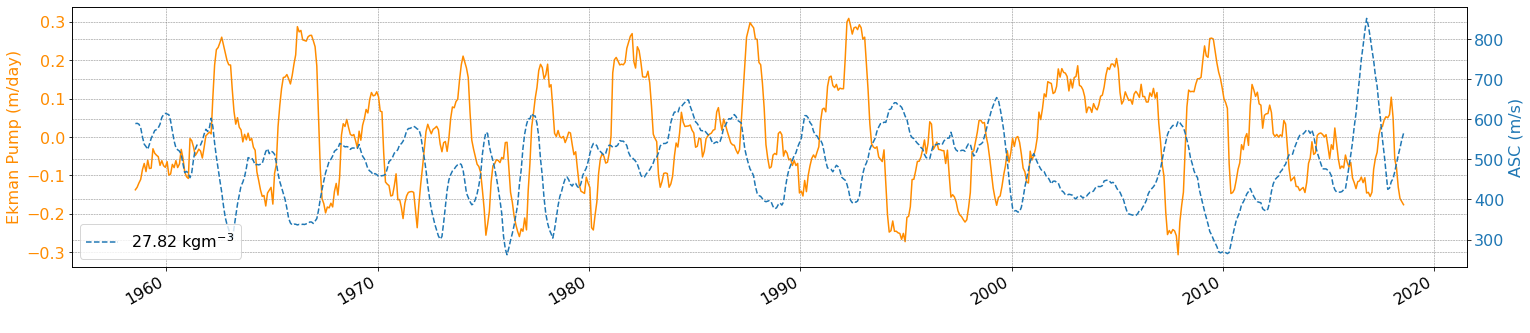

In [533]:
fontsize=16
fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)

ax1 = plt.subplot(4, 1, 2)
ekman_con_dr2.plot(color='darkorange')

ax1.set_ylabel('Ekman Pump (m/day)', fontsize=fontsize,color='darkorange')
ax1.tick_params(axis='y', labelcolor='darkorange',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
#plt.title('Monthly T (Box1) vs Zonal Wind (small grid; -65,-64.5S/-258,-252E) / Rolling mean',fontsize=fontsize)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.ylim([-0.8,0.8])
#plt.text(100,0.4,"cor = -0.73, lag = 4 months")


ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
iso2782_dth_r.plot(color='C0',linestyle='--')
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('ASC (m/s)', fontsize=fontsize, color='C0')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='C0',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='C0',linestyle='--',label='27.82 kgm$^{-3}$')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="lower left",fontsize=fontsize)
#plt.ylim([100,900])

#figdir = '/home/581/ns3783/Scripts/Figures'
#figdir = '/g/data/jk72/ns3783'
#filestr = figdir+'/test_series.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [673]:
cov2,cor_ekman,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(ekman_con_dr,u_speed_dr)

In [674]:
cor_ekman

<xarray.DataArray ()>
array(-0.5542671)
Coordinates:
    yu_ocean  float64 -64.99